<a href="https://www.kaggle.com/code/siddp6/simple-skip-connection?scriptVersionId=138508988" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import utility

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Initalisation

In [3]:
input_size, hidden_size, output_size = 10, 50, 5
num_samples = 10000
epochs = 100
input_data = torch.rand(num_samples, input_size)
target_data = torch.rand(num_samples, output_size)
loss_normal_3, loss_normal_6 = list(), list()
loss_skip_3, loss_skip_6 = list(), list()

# Normal Model (3 layered) (without skip-connection)

In [4]:
class NormalNet3(nn.Module):
    def __init__(self, input_size, output_size):
        super(NormalNet3, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, X):
        X = self.relu(self.layer_1(X))
        X = self.relu(self.layer_2(X))
        X = self.relu(self.layer_3(X))
        
        X = self.relu(X)
        
        return X

In [5]:
normal_model_3 = NormalNet3(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(normal_model_3.parameters(), lr=.01)

In [6]:
loss_normal_3 = utility.train_model(normal_model_3, epochs, input_data, target_data, criterion, optimizer, 5)

Epoch [5/100], Loss: 0.2840
Epoch [10/100], Loss: 0.2747
Epoch [15/100], Loss: 0.2658
Epoch [20/100], Loss: 0.2577
Epoch [25/100], Loss: 0.2504
Epoch [30/100], Loss: 0.2438
Epoch [35/100], Loss: 0.2378
Epoch [40/100], Loss: 0.2323
Epoch [45/100], Loss: 0.2274
Epoch [50/100], Loss: 0.2229
Epoch [55/100], Loss: 0.2188
Epoch [60/100], Loss: 0.2152
Epoch [65/100], Loss: 0.2119
Epoch [70/100], Loss: 0.2089
Epoch [75/100], Loss: 0.2062
Epoch [80/100], Loss: 0.2038
Epoch [85/100], Loss: 0.2016
Epoch [90/100], Loss: 0.1997
Epoch [95/100], Loss: 0.1980
Epoch [100/100], Loss: 0.1964


# Normal Model (7 layered) (without skip-connection)

In [7]:
class NormalNet7(nn.Module):
    def __init__(self, input_size, output_size):
        super(NormalNet7, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, hidden_size)        
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, hidden_size)
        self.layer_4 = nn.Linear(hidden_size, hidden_size)
        self.layer_5 = nn.Linear(hidden_size, hidden_size)
        self.layer_6 = nn.Linear(hidden_size, hidden_size)
        self.layer_7 = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, X):
        X = self.relu(self.layer_1(X))
        X = self.relu(self.layer_2(X))
        X = self.relu(self.layer_3(X)) 
        X = self.relu(self.layer_4(X)) 
        X = self.relu(self.layer_5(X)) 
        X = self.relu(self.layer_6(X)) 
        X = self.relu(self.layer_7(X)) 
        
        X = self.relu(X)
        
        return X

In [8]:
normal_model_7 = NormalNet7(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(normal_model_7.parameters(), lr=.01)

In [9]:
loss_normal_7 = utility.train_model(normal_model_7, epochs, input_data, target_data, criterion, optimizer, 5)

Epoch [5/100], Loss: 0.2984
Epoch [10/100], Loss: 0.2928
Epoch [15/100], Loss: 0.2874
Epoch [20/100], Loss: 0.2823
Epoch [25/100], Loss: 0.2775
Epoch [30/100], Loss: 0.2728
Epoch [35/100], Loss: 0.2684
Epoch [40/100], Loss: 0.2643
Epoch [45/100], Loss: 0.2603
Epoch [50/100], Loss: 0.2565
Epoch [55/100], Loss: 0.2529
Epoch [60/100], Loss: 0.2495
Epoch [65/100], Loss: 0.2462
Epoch [70/100], Loss: 0.2431
Epoch [75/100], Loss: 0.2402
Epoch [80/100], Loss: 0.2374
Epoch [85/100], Loss: 0.2348
Epoch [90/100], Loss: 0.2323
Epoch [95/100], Loss: 0.2299
Epoch [100/100], Loss: 0.2276


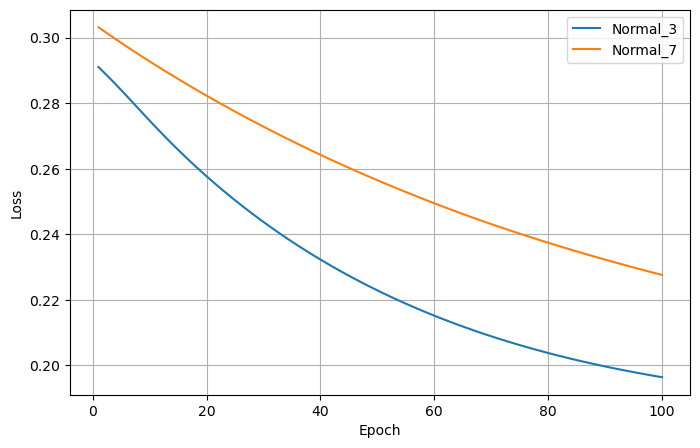

In [10]:
utility.plot_loss({"Normal_3": loss_normal_3, "Normal_7": loss_normal_7}, epochs)

# Skip Model (3 layered) (with skip-connection)

In [11]:
class SkipNet3(nn.Module):
    def __init__(self, input_size, output_size):
        super(SkipNet3, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, X):
        skip_connection = X
        
        X = self.relu(self.layer_1(X))
        X = self.relu(self.layer_2(X))
        X = self.relu(self.layer_3(X))
        
        X = self.relu(X + skip_connection)
        
        return X

In [12]:
skip_model_3 = SkipNet3(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(skip_model_3.parameters(), lr=.01)

In [13]:
loss_skip_3 = utility.train_model(skip_model_3, epochs, input_data, target_data, criterion, optimizer, 5)

RuntimeError: The size of tensor a (5) must match the size of tensor b (10) at non-singleton dimension 1

# Skip Model (7 layered) (with skip-connection)

In [ ]:
class SkipNet7(nn.Module):
    def __init__(self, input_size, output_size):
        super(SkipNet7, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, hidden_size)        
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, hidden_size)
        self.layer_4 = nn.Linear(hidden_size, hidden_size)
        self.layer_5 = nn.Linear(hidden_size, hidden_size)
        self.layer_6 = nn.Linear(hidden_size, hidden_size)
        self.layer_7 = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, X):
        skip_connection = X
            
        X = self.relu(self.layer_1(X))
        X = self.relu(self.layer_2(X))
        X = self.relu(self.layer_3(X)) 
        X = self.relu(self.layer_4(X)) 
        X = self.relu(self.layer_5(X)) 
        X = self.relu(self.layer_6(X)) 
        X = self.relu(self.layer_7(X)) 
        
        X = self.relu(X + skip_connection)
        
        return X

In [ ]:
skip_model_7 = SkipNet7(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(skip_model_7.parameters(), lr=.01)

In [ ]:
loss_skip_7 = utility.train_model(skip_model_7, epochs, input_data, target_data, criterion, optimizer, 5)

In [ ]:
utility.plot_loss({"Skip_3": loss_skip_3, "Skip_7": loss_skip_7}, epochs)